In [67]:
# Python calculation for the example and exercise from Lecture 4 notes
import numpy as np
import os
import math
import pandas as pd
import scipy.stats as stat
import scipy.interpolate
import statistics
from statistics import NormalDist

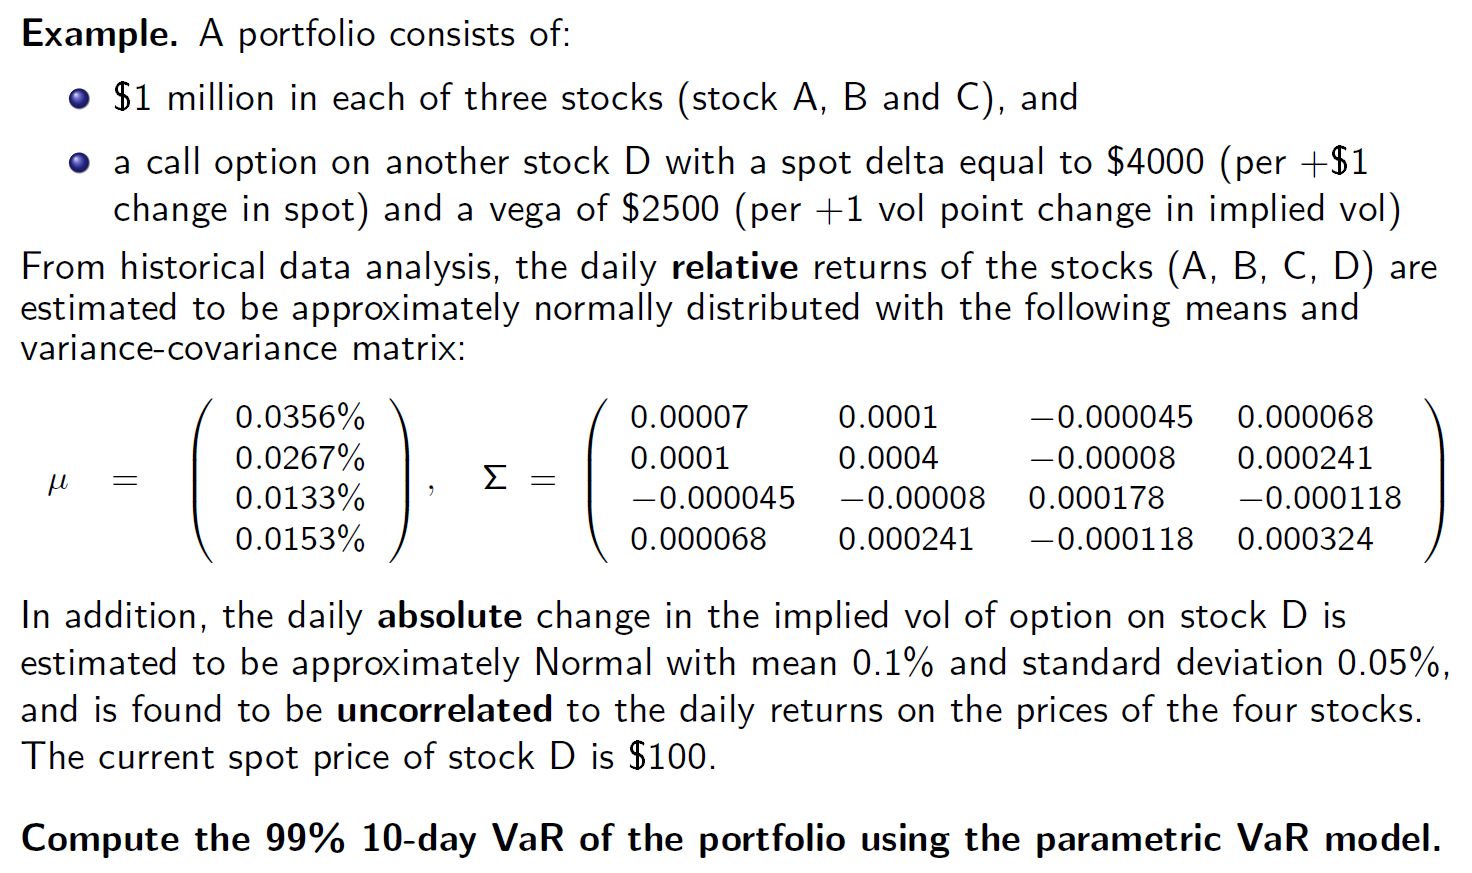

In [5]:
mu = [0.000356, 0.000267, 0.000133, 0.000153]
sigma = [[0.00007, 0.0001, -0.000045, 0.000068],
         [0.0001, 0.0004, -0.00008, 0.000241],
         [-0.000045, -0.00008, 0.000178, -0.000118],
         [0.000068, 0.000241, -0.000118, 0.000324]
        ]

mu10d = np.multiply(mu, 10)
sigma10d = np.multiply(sigma, 10)
w = np.array([1000000, 1000000, 1000000, 400000])
meanL = np.inner(w, mu10d) + 2500 * (0.001 * 10) / 0.01 
varianceL = np.dot(np.dot(w, sigma10d), np.transpose(w)) + 2500 * 2500 * 0.0005 * 0.0005 * 10

var = np.abs(stat.norm.ppf(0.01, loc=meanL, scale=np.sqrt(varianceL)))
print(f"The 10-day 99% VaR using the parametric VaR model is equal to: {var:,.0f}")

The 10-day 99% VaR using the parametric VaR model is equal to: 197,746


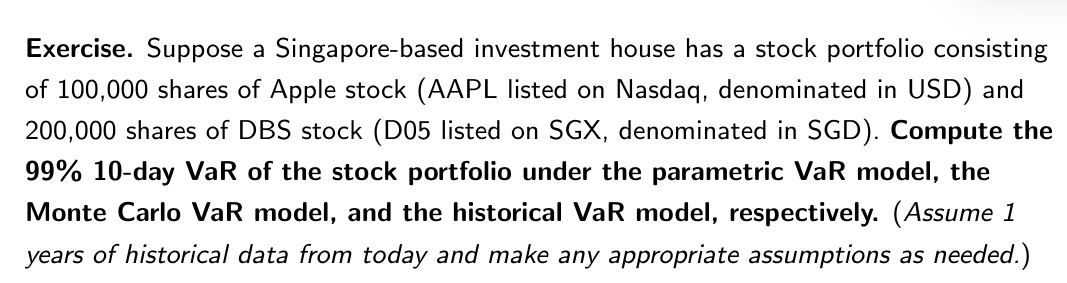

In [222]:
file_path = "D:/OneDrive/main/workspace/smu-teaching/SMUTeaching/2025/Lect5/"
offset = 693594

df_appl = pd.read_csv(file_path + "AAPL.csv").set_index('Date')
df_appl.index = pd.to_datetime(df_appl.index).date
df_appl = df_appl.sort_index()

df_dbs = pd.read_csv(file_path + "DBS.csv").set_index('Date')
df_dbs.index = pd.to_datetime(df_dbs.index).date
df_dbs = df_dbs.sort_index()

df_usdsgd = pd.read_csv(file_path + "USDSGD.csv").set_index('Date')
df_usdsgd.index = pd.to_datetime(df_usdsgd.index).date
df_usdsgd = df_usdsgd.sort_index()


d1 = [ d.toordinal()-693594  for d in df_appl.index.tolist()]
p1 = df_appl['Close'].tolist()
interp1 =  scipy.interpolate.interp1d(d1, p1)

d2 = [ d.toordinal()-693594  for d in df_dbs.index.tolist()]
p2 = df_dbs['Close'].tolist()
interp2 =  scipy.interpolate.interp1d(d2, p2)

d3 = [ d.toordinal()-693594  for d in df_usdsgd.index.tolist()]
p3 = df_usdsgd['Close'].tolist()
interp3 =  scipy.interpolate.interp1d(d3, p3)

dlist = list(set(d1) | set(d2) | set(d3))

numchg = len(dlist)-1
appl = [ interp1(dlist[i+1]).flat[0] / interp1(dlist[i]).flat[0] - 1.0  for i in range(numchg) ]
dbs = [ interp2(dlist[i+1]).flat[0] / interp2(dlist[i]).flat[0] - 1.0  for i in range(numchg) ]
usdsgd = [ interp3(dlist[i+1]).flat[0] / interp3(dlist[i]).flat[0] - 1.0  for i in range(numchg) ]

alldata = { 'appl' : appl,
           'dbs' : dbs,
           'usdsgd' : usdsgd }

df_all = pd.DataFrame(alldata, columns=['appl', 'dbs', 'usdsgd'])

corr_mat = df_all.corr()
cov_mat = df_all.cov()

appl_mean = np.average(appl)
appl_std = statistics.stdev(appl)
dbs_mean = np.average(dbs)
dbs_std = statistics.stdev(dbs)
usdsgd_mean = np.average(usdsgd)
usdsgd_std = statistics.stdev(usdsgd)

mean_vec = np.array([appl_mean, dbs_mean, usdsgd_mean])

mean10d_vec = np.array([appl_mean*10, dbs_mean*10, usdsgd_mean*10])
cov10d_mat = (cov_mat * 10).to_numpy()


# Parametric VaR
usdsgd_p0 = 1.354
appl_p0 = 227.63
dbs_p0 = 44.68
n_appl = 100000
n_dbs = 200000
w_parametric = np.array([n_appl*appl_p0*usdsgd_p0, n_dbs*dbs_p0, n_appl*appl_p0*usdsgd_p0])
m10d = np.inner(w_parametric, mean10d_vec)
v10d = np.inner(np.dot(w_parametric, cov10d_mat), w_parametric)
var10d = np.abs(stat.norm.ppf(0.01, loc=m10d, scale=np.sqrt(v10d)))
m1d =  np.inner(w_parametric, mean_vec)
v1d = np.inner(np.dot(w_parametric, cov_mat), w_parametric)
var1d = np.abs(stat.norm.ppf(0.01, loc=m1d, scale=np.sqrt(v1d)))
print("")
print("")
print("============================================================================================================================")
print(f"Parametric VaR [1d, 99%]: {var1d:,.0f}")
print(f"Parametric VaR [10d, 99%]: {var10d:,.0f}")
print("============================================================================================================================")


# full revaluation 1d pnl evaluation
def pnl1d_full(appl_daily_return, dbs_return, usdsgd_return):
    return n_appl*appl_p0*usdsgd_p0*((1+appl_daily_return)*(1+usdsgd_return)-1) + n_dbs*dbs_p0*((1+dbs_return)-1)

# sensitivity based 1d pnl evaluation 
def pnl1d_sen(appl_daily_return, dbs_return, usdsgd_return):
    return n_appl*appl_p0*usdsgd_p0*(appl_daily_return+usdsgd_return) + n_dbs*dbs_p0*dbs_return


# full revaluation 10d pnl evaluation
def pnl10d_full(returns):
    a10d = 0.0
    fx10d = 0.0
    d10d = 0.0
    for i in range(0,10):
        a10d = a10d + returns[i][0]
        fx10d = fx10d  +returns[i][2]
        d10d = d10d  +returns[i][1]
    return n_appl*appl_p0*usdsgd_p0*a10d + n_appl*appl_p0*usdsgd_p0*fx10d + n_dbs*dbs_p0*d10d

# sensitivity based 10d pnl evaluation 
def pnl10d_sen(returns):
    a10d = 1.0
    d10d = 1.0
    for i in range(0,10):
        a10d = a10d * (1+returns[i][0])*(1+returns[i][2])
        d10d = d10d * (1+returns[i][1])
    return n_appl*appl_p0*usdsgd_p0*(a10d-1)  +n_dbs*dbs_p0*(d10d-1)
    
# Monte Carlo VaR
n_mc = 100000
factor_loadings = np.linalg.cholesky(corr_mat)
uniforms = np.random.uniform(size=(n_mc,3))
snorms = [ [NormalDist().inv_cdf(u) for u in r]  for r in uniforms]
snorms_correlated = np.dot(snorms, factor_loadings.transpose())
return1d_sample = [ [ appl_mean + appl_std * z[0],   dbs_mean + dbs_std * z[1], usdsgd_mean + usdsgd_std * z[2] ]  for z in snorms_correlated]
pnl1d_full_sample = [ pnl1d_full(s[0], s[1], s[2])  for s in return1d_sample]
var1d_full_mc = np.abs(np.percentile(pnl1d_full_sample, 1))
pnl10d_full_sample = [ pnl10d_full(return1d_sample[k*10:(k+1)*10]) for k in range(0, int(n_mc/10)) ]
var10d_full_mc = np.abs(np.percentile(pnl10d_full_sample, 1))
pnl1d_sen_sample = [ pnl1d_sen(s[0], s[1], s[2])  for s in return1d_sample]
var1d_sen_mc = np.abs(np.percentile(pnl1d_sen_sample, 1))
pnl10d_sen_sample = [ pnl10d_sen(return1d_sample[k*10:(k+1)*10]) for k in range(0, int(n_mc/10)) ]
var10d_sen_mc = np.abs(np.percentile(pnl10d_sen_sample, 1))

print("")
print("")
print("============================================================================================================================")
print("Monte Carlo VaR:")
print(f"VaR [1d, 99%], Full Revaluation: {var1d_full_mc:,.0f}") 
print(f"VaR [10d, 99%], Full Revaluation: {var10d_full_mc:,.0f}") 
print(f"VaR [10d, 99%] using square-root-of-time rule: {np.sqrt(10)*var1d_full_mc:,.0f}") 
print("")
print(f"VaR [1d, 99%], Sensitivity: {var1d_sen_mc:,.0f}") 
print(f"VaR [10d, 99%], Sensitivity: {var10d_sen_mc:,.0f}") 
print("============================================================================================================================")


# Historical VaR
hist_returns = df_all.to_numpy().tolist()
pnl1d_full_hist_sample = [ pnl1d_full(s[0], s[1], s[2])  for s in hist_returns]
var1d_full_hist = np.abs(np.percentile(pnl1d_full_hist_sample, 1))
pnl1d_sen_hist_sample = [ pnl1d_sen(s[0], s[1], s[2])  for s in hist_returns]
var1d_sen_hist = np.abs(np.percentile(pnl1d_sen_hist_sample, 1))
print("")
print("")
print("============================================================================================================================")
print("Historical VaR:")
print(f"VaR [1d, 99%], Full Revaluation: {var1d_full_hist:,.0f}") 
print(f"VaR [10d, 99%] using square-root-of-time rule: {np.sqrt(10)*var1d_full_hist:,.0f}")
print("")
print(f"VaR [1d, 99%], Sensitivity: {var1d_sen_hist:,.0f}") 
print("============================================================================================================================")






Parametric VaR [1d, 99%]: 1,042,033
Parametric VaR [10d, 99%]: 3,018,277


Monte Carlo VaR:
VaR [1d, 99%], Full Revaluation: 1,043,732
VaR [10d, 99%], Full Revaluation: 3,037,724
VaR [10d, 99%] using square-root-of-time rule: 3,300,570

VaR [1d, 99%], Sensitivity: 1,044,095
VaR [10d, 99%], Sensitivity: 2,956,651


Historical VaR:
VaR [1d, 99%], Full Revaluation: 1,027,655
VaR [10d, 99%] using square-root-of-time rule: 3,249,730

VaR [1d, 99%], Sensitivity: 1,028,280
